In [1]:
import pandas as pd
from collections import defaultdict

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid

from utils import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Cleaning  & preparing data

In [2]:
gold_df = pd.read_csv("./data/data.tsv", sep='\t')
gold_df = gold_df[['tweet', 'sentiment']]
# drop records where sentiment is none or mixed
gold_df = gold_df.drop(gold_df[gold_df.sentiment == 'mixed'].index)
gold_df = gold_df.drop(gold_df[gold_df.sentiment == 'none'].index)
gold_df.head()

,tweet,sentiment
2,ناشرینترین کەس ئەو کەسەیە کە هەڵەکانت تۆمار دە...,negative
3,ئیمڕۆ هاوکارەکەم وتی تەک مناڵەکانا چووگین بۆ د...,negative
4,بە خۆر بڵێ کیس و شت نەکا وە با، مانگیش شەوانە ...,neutral
5,ئیشێ من ئەوەیە هەموو ڕۆژێ لە خەوێ‌ هەستم برێم:...,negative
6,ئەرێ ئێوەش ئاوان؟ لە ماڵەوە بێزارن و و کە دەچی...,negative


In [3]:
gold_df.sentiment.value_counts()

negative    639
positive    292
neutral     254
Name: sentiment, dtype: int64

In [4]:
silver_df = pd.read_csv('./data/silver_data.csv')

In [8]:
# Sample 400 records from silver_df when sentiment is neutral
neu_aug = silver_df[silver_df.sentiment == 'neutral'].sample(700 - 254)
pos_aug = silver_df[silver_df.sentiment == 'positive'].sample(700 - 292)
neg_aug = silver_df[silver_df.sentiment == 'negative'].sample(700 - 639)
df = pd.concat([neu_aug, pos_aug, neg_aug, gold_df], ignore_index=True)

In [9]:
# df = gold_df

In [10]:
df.sentiment.value_counts()

neutral     700
positive    700
negative    700
Name: sentiment, dtype: int64

### Grouping emojis

In [11]:
emojis = {'ئەرێنی': ' 😊 😃 😄 😍 😘 😎 😇 🤗 🤩 🤔 🥰 🥳 🙂 😉 😌 😁 😻 😺 🌞 😂 ❤ ♥ 😍 😊 👌 💕 👏 😁 ☺ ♡ 🙏 ✌ 😄 💃 💖 😃 🎉 😜 🌸 💜 💙 ✨ 💗 ★ 😎 💋 😋 🙌 🙈 💪 😁 🔥 💯',
         'نەرێنی': '😠 😡 😤 😩 😭 😰 😱 😨 😫 😖 😞 😒 😔 😕 😫 😩 😢 😠 😣 😤 😦 😧 😨 😩 😫 😬 😭 😯 😰 😱 😲 😳 😴 😵 😶 😷 🙁 🤔 🤕 🤒 🤢 🤮 🤧 😇 🤠 🤡 🤥 🤫 🤭 🧐 🤓',
         'ئاسایی': '😐 😶 😑 😬 😯 😕 😒 '}

emoji_to_sentiment = {}
for k,v in emojis.items():
    for i in set(v.split()):
        emoji_to_sentiment[i] = f" {k} " # so the word does not attched directly to its surrounding words

In [12]:
# replace emojis with their corresponding word
# df['tweet'] = df['tweet'].replace(emoji_to_sentiment, regex=True)

In [13]:
df['cleaned_text'] = df['tweet'].apply(lambda x:clean_text(x, lemma=True, emoji=False))

In [14]:
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': -1, 'neutral': 0})
df.head()

,tweet,sentiment,cleaned_text
0,دوای شەش ساڵ خوشکم هاتەوە کوردستان😭😍,0,دوان شەش ساڵ خوشک هاتەوە کوردستان😭😍
1,بڕەکەی کە 134 ملیار و 455 ملیۆن دینارە,0,بڕ کە 134 ملیار و 455 ملیۆن دینار
2,دا بە منیش بڵێن لە دینوو بەم قونم وە خرو کەوت,0,دا بوون نیشتن وتن لە دین بردن قونم وە خرو کەوتن
3,سوید پەنابەرێکی باکووری کوردستان ڕادەستی تورکی...,0,سوید پەنابەر باکوور کوردستان ڕادەستی تورکیا دە...
4,ئەگە وێنەمان لێیان هەبێ بە هەشتەگەوە توییتیان ...,0,گەین وێنە لێ هەبێ بوون هەشتەگەوە توییتیان بۆ دان


### Splitting the dataset

In [15]:
RS = 42

In [16]:
X = df.loc[:, 'cleaned_text']
y = df.loc[:, 'sentiment']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)



## Modeling

### Building the pipeline

In [17]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', ClfSwitcher())
])

In [18]:
grid = ParameterGrid({
    'clf__estimator': [
        LogisticRegression(multi_class="multinomial",solver='lbfgs',random_state=RS),
        LinearSVC(multi_class="crammer_singer", random_state=RS),
        RandomForestClassifier(n_estimators=30, criterion='entropy',random_state=RS),
        DecisionTreeClassifier(random_state=RS),
        
    ],
    'tfidf__ngram_range': [(1, 1)]
})

models = [
   'LR', 'SVM', 'RF', 'DT',
]
multi_class_metrics = pd.DataFrame()

In [19]:
for model, params in tqdm(zip(models, grid), total=len(models)):
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    machine_learning = score(y_test, y_pred, model)
    multi_class_metrics = pd.concat([multi_class_metrics, machine_learning])
    

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.57it/s]


In [20]:
multi_class_metrics

,precision,recall,f1,accuracy
LR,0.589177,0.580952,0.582946,0.580952
SVM,0.565859,0.564286,0.563999,0.564286
RF,0.540441,0.533333,0.534231,0.533333
DT,0.477015,0.473810,0.474462,0.473810


In [21]:
biLSTM = pd.DataFrame({'precision': 0.57, 'recall': 0.571, 'f1': 0.576, 'accuracy': 0.58 }, index=['BiLSTM'])
multi_class_metrics = pd.concat([multi_class_metrics, biLSTM])

 Treating the problem as a multi-class problem gives us much much higher accuracy

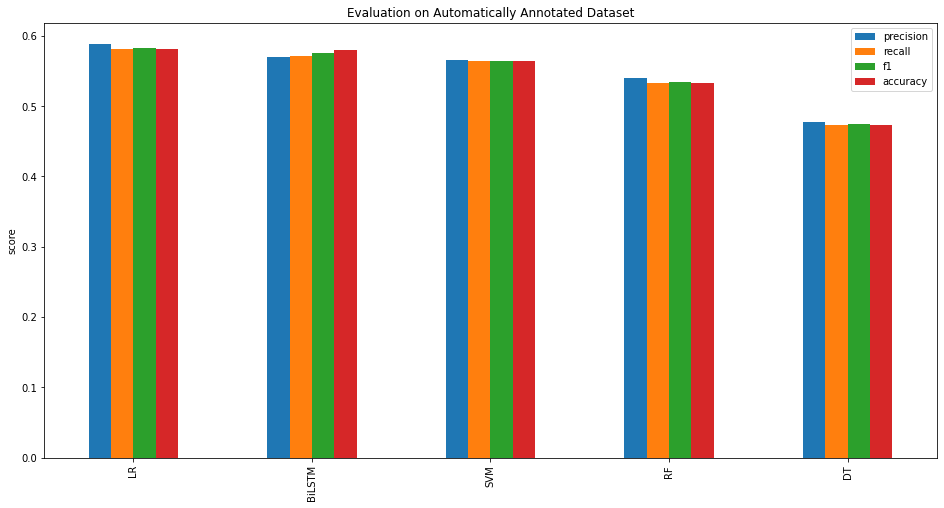

In [22]:
plot_metrics(multi_class_metrics, title="Evaluation on Automatically Annotated Dataset")

### Best Model & Inference


In [23]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(multi_class="crammer_singer", random_state=RS))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
score(y_test, y_pred, 'lr')

,precision,recall,f1,accuracy
lr,0.565859,0.564286,0.563999,0.564286


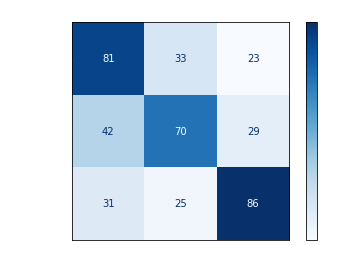

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'white'
matrix = plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues,display_labels=['negative', 'neutral', 'positive'] )
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [25]:
labels = {
    0: 'neutral',
    -1: 'negative',
    1: 'positive'
} 

def create_test_data(txt):
    d = {'cleaned_text' : clean_text(txt)}
    df = pd.DataFrame(d, index=[0])
    return df


samples = [
    'خۆشەویستی جوانی، باش حەز',
    'جلە ڕەشەکەت ئەکەیت جوانتریت ڕێک گوڵە ڕەشانە دەچیت دەگمەنن 🥀',
    "حەزئەکەم چا ئەوەندە گەرم بێ. بۆم بکرایە دەمم ئەنا بە قۆرییەکەوە!",
    "وێ ڕا بانگم دەکا دەلێم گیان دەلێ جوابی هەست ناسکیه ئەوە نیه"
]

for x in samples:
    c_res = pipeline.predict(create_test_data(x))[0]
    print(x, '=', labels[c_res])


خۆشەویستی جوانی، باش حەز = neutral
جلە ڕەشەکەت ئەکەیت جوانتریت ڕێک گوڵە ڕەشانە دەچیت دەگمەنن 🥀 = neutral
حەزئەکەم چا ئەوەندە گەرم بێ. بۆم بکرایە دەمم ئەنا بە قۆرییەکەوە! = neutral
وێ ڕا بانگم دەکا دەلێم گیان دەلێ جوابی هەست ناسکیه ئەوە نیه = neutral
